In [5]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Reading Raster with rasterio

In [6]:
raster_path = "/home/user/projects/africa_data/data/images/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_TCI.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

Checking Raster shape and Meta

In [7]:
print(raster_img.shape)

(3, 10980, 10980)


In [8]:
raster_meta

{'count': 3,
 'crs': CRS({'init': 'epsg:32734'}),
 'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'height': 10980,
 'nodata': None,
 'transform': Affine(10.0, 0.0, 499980.0,
        0.0, -10.0, 6900040.0),
 'width': 10980}

Using rasterio reshape to plot an image in matplotlib

In [9]:
raster_img = reshape_as_image(raster_img)


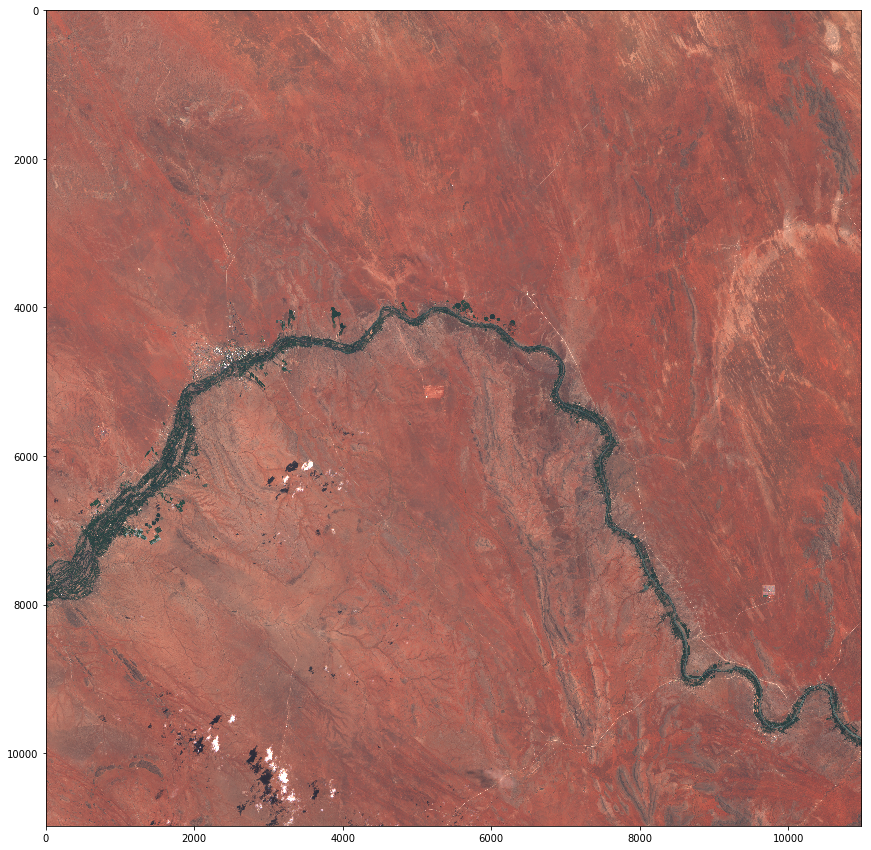

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

Reading train labels with GeoPandas

In [11]:
train_df = gpd.read_file("/home/user/projects/africa_data/data/train/train/train.shp")
print(len(train_df))
train_df.head(5)

2497


,Field_Id,Area,Subregion,Crop_Id_Ne,geometry
0,1,0.915905,3,8,POLYGON ((2467881.175041331 -3352032.059296422...
1,2,2.064410,3,6,"POLYGON ((2468428.90623293 -3351993.17305059, ..."
2,3,1.080300,3,8,POLYGON ((2468333.745293362 -3352058.485056543...
3,4,1.316190,3,8,POLYGON ((2468607.857733211 -3352012.337531495...
4,7,5.529220,3,8,"POLYGON ((2468646.08520868 -3351706.201920062,..."


Checking coordinates of polygon using Polygon methods

In [12]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [2467881.1750413314, 2468026.166997987, 2468030.9295075075, 2467906.045924405, 2467881.1750413314]),
 array('d', [-3352032.0592964217, -3352002.1613220456, -3352046.3468240052, -3352113.021952709, -3352032.0592964217]))

Trying to cut fields from Raster

In [13]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 2497 files


Converting GeoDataframe to raster CRS

In [14]:
train_df = gpd.read_file("/home/user/projects/africa_data/data/train/train/train.shp")


# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]

# assigning crs
train_df.crs = {'init' :'epsg:3395'}

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

Cutting fields from Raster

In [15]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "/home/user/projects/africa_data/data/images_cropped_rgb/article"
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['Field_Id']) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
#         print(e)
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 150 files


Preparing binary mask

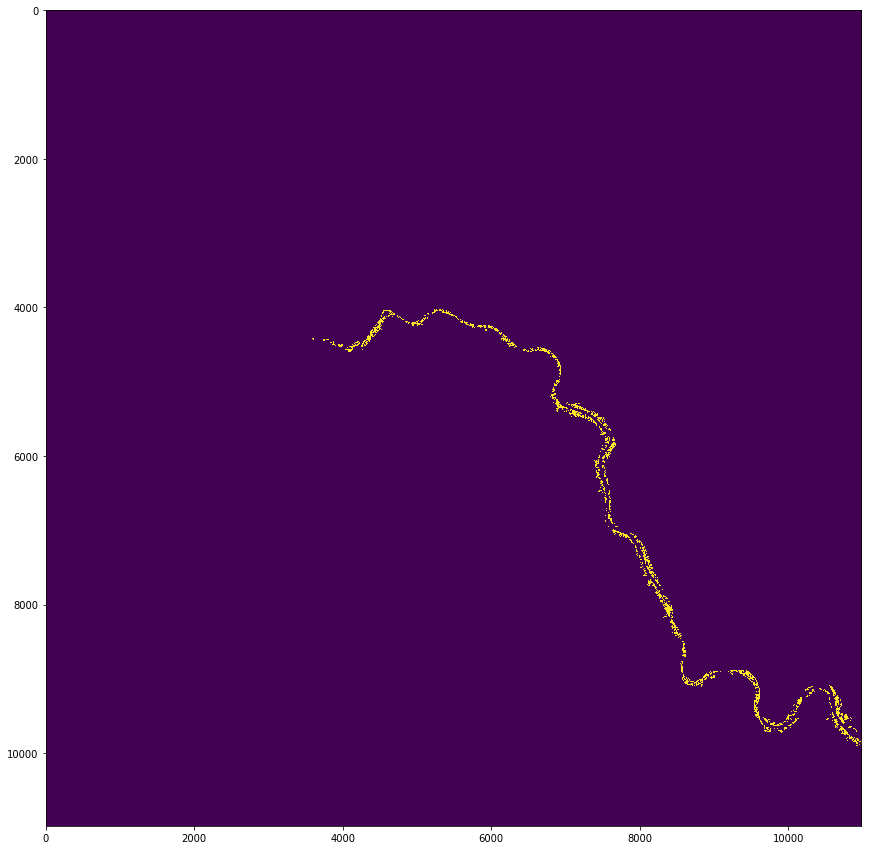

In [16]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

Saving binary mask

In [17]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("/home/user/projects/africa_data/data/train/train/train.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)